In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 1. Carregar o dataset

In [ ]:
# 1. Carregar o dataset (apenas as primeiras 50.000 linhas)
nome_arquivo = 'dataset_regressao_etiquetado.csv'
df = pd.read_csv(nome_arquivo, skiprows=1, nrows=150000)

### 2. Exploração e pré-processamento dos dados

Resumo estatístico:
                 f0            f1            f2            f3            f4  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean      -0.002209      0.008093     -0.002314     -0.010246      0.008884   
std        1.003134      1.000091      1.002423      1.004549      0.998397   
min       -4.295391     -4.465604     -4.829436     -4.413886     -3.997015   
25%       -0.678939     -0.667536     -0.679481     -0.686011     -0.662932   
50%       -0.002264      0.008724     -0.004295     -0.007387      0.008513   
75%        0.668623      0.682920      0.672047      0.667773      0.681957   
max        3.859376      4.562115      3.918185      4.479084      4.202026   

                 f5            f6            f7            f8            f9  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean      -0.004995      0.000422     -0.006041     -0.002668     -0.000588   
std        1.000610      0.9985

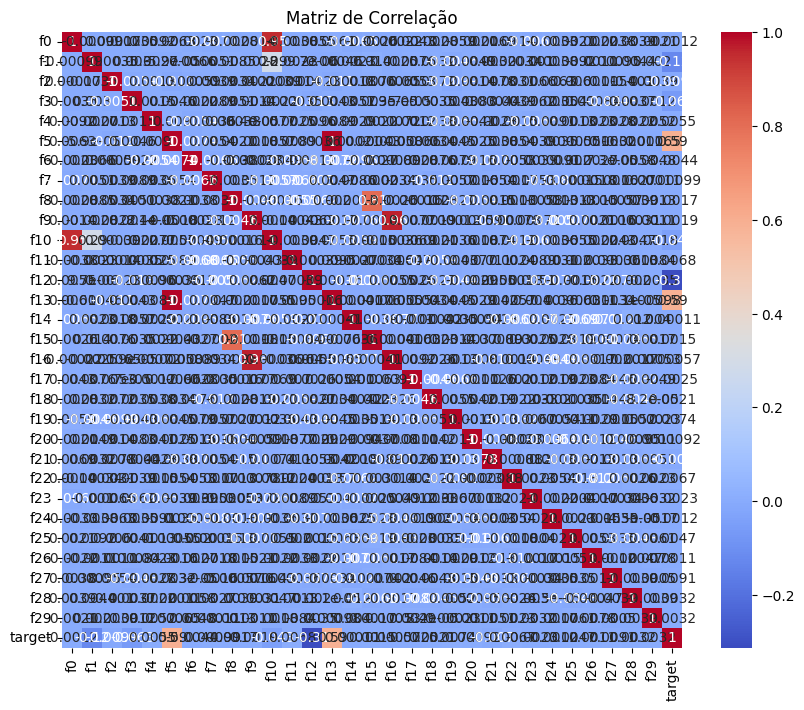

In [3]:
# Tratamento de valores faltantes
df.fillna(df.median(), inplace=True)

# Análise exploratória
print("Resumo estatístico:")
print(df.describe())

# Correlação entre as features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.show()

# Detecção de outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

### 3. Separar atributos e rótulo

In [4]:
X = df.drop(columns=['target'])
y = df['target']

# Identificar colunas numéricas e categóricas
colunas_numericas = X.select_dtypes(include=['float64', 'int64']).columns
colunas_categoricas = X.select_dtypes(include=['object']).columns

# Pipeline de pré-processamento
preprocessador = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), colunas_numericas),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), colunas_categoricas)
    ]
)

### 4. Divisão dos dados

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 5. Configuração dos modelos base

In [6]:
modelos = {
    'KNN': {
        'pipeline': Pipeline([
            ('preprocess', preprocessador),
            ('model', KNeighborsRegressor())
        ]),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance']
        }
    },
    'Ridge': {
        'pipeline': Pipeline([
            ('preprocess', preprocessador),
            ('model', Ridge())
        ]),
        'params': {
            'model__alpha': [0.1, 1.0, 10.0]
        }
    },
    'SVR': {
        'pipeline': Pipeline([
            ('preprocess', preprocessador),
            ('model', SVR())
        ]),
        'params': {
            'model__kernel': ['rbf', 'linear'],
            'model__C': [0.1, 1, 10],
            'model__epsilon': [0.1, 0.2, 0.5]
        }
    },
    'GradientBoosting': {
        'pipeline': Pipeline([
            ('preprocess', preprocessador),
            ('model', GradientBoostingRegressor(random_state=42))
        ]),
        'params': {
            'model__n_estimators': [50, 100, 150],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    'RandomForest': {
        'pipeline': Pipeline([
            ('preprocess', preprocessador),
            ('model', RandomForestRegressor(random_state=42))
        ]),
        'params': {
            'model__n_estimators': [50, 100, 150],
            'model__max_depth': [None, 10, 20]
        }
    }
}

### 6. Treinamento e avaliação dos modelos base

In [7]:
melhores_modelos = {}
tempos_treinamento = {}

for nome, cfg in modelos.items():
    print(f"\nTreinando {nome}...")
    inicio = time()
    grid = GridSearchCV(cfg['pipeline'], cfg['params'], cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    fim = time()
    y_pred = grid.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Melhores parâmetros: {grid.best_params_}")
    print(f"R² no teste: {r2:.4f}")
    print(f"MSE no teste: {mse:.4f}")
    print(f"MAE no teste: {mae:.4f}")

    melhores_modelos[nome] = {
        'melhores_parametros': grid.best_params_,
        'r2_teste': r2,
        'mse_teste': mse,
        'mae_teste': mae
    }
    tempos_treinamento[nome] = fim - inicio

# Salvar os melhores modelos em um arquivo JSON
with open('melhores_modelos.json', 'w') as f:
    json.dump(melhores_modelos, f, indent=4)


Treinando KNN...
Melhores parâmetros: {'model__n_neighbors': 7, 'model__weights': 'distance'}
R² no teste: 0.3643
MSE no teste: 1.2915
MAE no teste: 0.9110

Treinando Ridge...
Melhores parâmetros: {'model__alpha': 10.0}
R² no teste: 0.4803
MSE no teste: 1.0557
MAE no teste: 0.8195

Treinando SVR...
Melhores parâmetros: {'model__C': 1, 'model__epsilon': 0.5, 'model__kernel': 'rbf'}
R² no teste: 0.4900
MSE no teste: 1.0360
MAE no teste: 0.8167

Treinando GradientBoosting...
Melhores parâmetros: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
R² no teste: 0.5148
MSE no teste: 0.9857
MAE no teste: 0.7936

Treinando RandomForest...
Melhores parâmetros: {'model__max_depth': 10, 'model__n_estimators': 150}
R² no teste: 0.5081
MSE no teste: 0.9994
MAE no teste: 0.7992


### 7. Construção do ensemble

In [8]:
# Carregar os melhores parâmetros
with open('melhores_modelos.json', 'r') as f:
    dados = json.load(f)

# Instanciar os modelos com os melhores parâmetros
modelos_ensemble = []
for nome_modelo, conteudo in dados.items():
    if nome_modelo == 'KNN':
        modelo = KNeighborsRegressor(**conteudo['melhores_parametros'])
    elif nome_modelo == 'Ridge':
        modelo = Ridge(**conteudo['melhores_parametros'])
    elif nome_modelo == 'SVR':
        modelo = SVR(**conteudo['melhores_parametros'])
    elif nome_modelo == 'GradientBoosting':
        modelo = GradientBoostingRegressor(**conteudo['melhores_parametros'])
    elif nome_modelo == 'RandomForest':
        modelo = RandomForestRegressor(**conteudo['melhores_parametros'])
    modelos_ensemble.append((nome_modelo, modelo))

# Criar o ensemble com VotingRegressor
ensemble = VotingRegressor(estimators=modelos_ensemble)
ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)

# Avaliar o ensemble
r2_ensemble = r2_score(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)

print("\nDesempenho do Ensemble:")
print(f"R²: {r2_ensemble:.4f}")
print(f"MSE: {mse_ensemble:.4f}")
print(f"MAE: {mae_ensemble:.4f}")

TypeError: KNeighborsRegressor.__init__() got an unexpected keyword argument 'model__n_neighbors'

### 8. Visualizações

In [ ]:
# Comparativo de desempenho
resultados = pd.DataFrame(melhores_modelos).T
resultados['Ensemble'] = [r2_ensemble, mse_ensemble, mae_ensemble]
resultados.plot(kind='bar', figsize=(10, 6))
plt.title('Comparativo de Desempenho')
plt.ylabel('Métricas')
plt.show()

In [ ]:
# Exportar resultados para um arquivo CSV
resultados_df = pd.DataFrame(melhores_modelos).T
resultados_df['R2_Ensemble'] = r2_ensemble
resultados_df['MSE_Ensemble'] = mse_ensemble
resultados_df['MAE_Ensemble'] = mae_ensemble

# Salvar em um arquivo CSV
resultados_df.to_csv('resultados_modelos.csv', index=True)
print("Resultados exportados para 'resultados_modelos.csv'")